In [21]:
import numpy as np
import matplotlib.pyplot as plt

# Computing the energy of a hydrogen molecule on a superconducting quantum processor

The goal of this project is to understand how to compute the ground state energy of a hydrogen molecule using a "noisy" quantum computer, namely a quantum computer with physical errors. We are going to learn about two main methods to perform this task by following a recent study by O'Malley et al from the Google Quantum AI team, published in the Physical Review X journal. The paper can be downloaded from arXiv at: http://arxiv.org/abs/1512.06860 (but you should have received a printed version of it).


The present Jupyter notebook will allow you to understand part of O'Malley et al's study. You will in particular be able to rewrite the quantum circuits used by the scientists and run perfect and noisy simulations of the quantum algorithms described in the paper. The goal of this session is to understand the pros and cons of each method and get a better understanding of hardware challenges.

## Instructions

During the first session (Lecture n°7), each group (from 1 to 4) will focus on different aspects of the study:

- **Group 1**: Variational Quantum Eigensolving (VQE), with a deeper focus on hardware noise
- **Group 2**: Variational Quantum Eigensolving (VQE), with an extension to an error mitigation method
- **Group 3**: Quantum Phase Estimation (QPE)
- **Group 4**: Iterative Quantum Phase Estimation (IQPE)


During the second session (Lecture n°8), each group will give a **20-minute presentation** to the other three groups, so that at the end of the presentations all groups will have the complete picture of what one can do to study the dihydrogen molecule.

Here are a few guidelines for this presentation:

- **All the students in the group should have a more or less equal speaking time during the presentation.**
- Showing plots and explanatory diagrams will be appreciated
- Equations should be kept to a minimum (but sometimes showing one equation is simpler than a long explanation!)
- Not more than 1 slide per minute!
- Communicating with other groups is allowed and recommended, provided your group tackles its own topic during the presentation!
- Looking up unknown aspects on the internet is allowed and recommended!


<div class="alert alert-block alert-info">
    
The questions below (**starting with a star: (*)**) will guide you and should ideally be addressed during the presentation. The answers are either in the paper by O'Malley et al, or can be answered by writing a quantum program. I will also be in the different rooms to help you answer the questions. Questions with a sharp sign (**(#)**) are difficult and optional questions.

</div>

It is recommended to read the article (without focussing on all the details!). If you have time left at the end of the session, feel free to look at the sections of other groups to learn about other ways to tackle the problem!


Finally, at the beginning of the second session (Lecture n°8), each group will **hand in a Jupyter notebook with the code they used to prepare the presentation** (one notebook per group!). 

The final grade will take into account the presentation (3/4 of the grade) and the code (1/4 of the grade).

## Quantum programming environment

To execute the quantum programs, you will need to install the Python library called **myQLM** on your laptop. It can be installed by running the command

``pip install myqlm``

Then, you need to clone the course's repository to have access to the notebook and some helper functions:

``git clone https://github.com/tayral/phy580_2022``

It is highly advised to use the online documentation of myQLM at https://myqlm.github.io.


Should you encounter problems with the installation (which may happen for Mac users using Anaconda), you can instead use "myBinder" to run the computations:
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tayral/phy580_2022/HEAD)

... and open the ``dihydrogen.ipynb`` notebook.

Some pieces of code have already been written to help you. They are located in the same github repository as the one where you found this notebook:

- ``omalley_utils.py``: contains a function to load the Hamiltonians for various bond distances
- ``qpe_utils.py``: contains functions that can be useful for quantum phase estimation (groups 3 and 4)
- ``tuto_utils.py``: contains a function to compute the matrix representation of a Hamiltonian
- ``depolarizing_plugin_vec.py``: contains a "plugin" for noisy simulation

Reminder: in a Jupyter notebook, to print the documentation of a given function (say ``my_function``), you just have to type ``my_function?`` in a cell and press MAJ+ENTER.

If you encounter programming issues or come up with physics questions during the session, feel free to ask me!

## The Hamiltonian of the dihydrogen molecule: from fermions to qubits (ALL GROUPS)

The goal of this work is to determine the lowest eigenvalue (ground state) of the Hamiltonian $H(d)$ of the dihydrogen molecule for various bond distances $d$.

The Hamiltonian of H$_2$ describes the kinetic and interaction energies of the nucleus and electrons of the molecule. Since the nuclei are assumed to be at fixed distance $d$ (Born-Oppenheimer approximation), only electronic operators appear in the formula for the total energy (the nuclei only contribute a constant known offset to this energy). Since electrons are fermions, these creation and annihilation operators obey a "fermionic" algebra that ensures that the corresponding wavefunctions anticommute upon exchange of two particles. 

In order to handle this Hamiltonian with a quantum computer, O'Malley et al had to translate this Hamiltonian written in a fermionic language to a "qubit" Hamiltonian, namely written in terms of Pauli operators, or in other words in a spin-1/2 algebra: this is the natural language for quantum computers, whose building blocks are **qubits**, aka **spin-1/2**, aka **two-level systems**!

After these transformations (called "Bravyi-Kitaev transformations"), the Hamiltonian ends up in the following form:

$$H = \lambda_0 I + \sum_{i=1}^{M} \lambda_i P_i$$

with $\lambda_i$ real coefficients, and $P_i$ products of Pauli operators. For instance, $P_i = \sigma^x_{0}$ or $P_i = \sigma^y_{2} \sigma^z_{4}$. From now on, we will denote $\sigma^x$ by $X$, and so on.


For the H$_2$ molecule, the Hamiltonian takes the form:
$$H = \lambda_0 I + \lambda_1 Z_0 + \lambda_2 Z_1 + \lambda_3 Z_0 Z_1 + \lambda_4 Y_0 Y_1 + \lambda_5 X_0 X_1 $$

In particular, we notice that the Hamiltonian acts on two qubits.

The $\lambda_i$ coefficients depend on the bond distance $d$.

<div class="alert alert-block alert-info">
    
- **(*)** If $H$ were represented as a matrix, what would its size be? 
- **(*)** In general, if the Hamiltonian describes $N$ fermionic orbitals, how many qubits should it correspond to?
- **(*)** For the H$_2$ molecule, how many orbitals do we need in principle? Does the number of qubits O'Malley take in their study correspond to what you expect?
- **(#)** Why? (Hint: look at the explanation after Equation A.5. This question will be easier to answer at the end of the session, once you know about the methods)
</div>

## Loading the data (ALL GROUPS)

In the following cell, we load these coefficients and products and store them in a ``Observable`` object. We also load, for future use, a list of times $t_0$ (used in quantum phase estimation). 

In [1]:
from omalley_utils import load_omalley_data_ordered
hamilt, qpe_t0 = load_omalley_data_ordered("data/omalley_data_v2.csv", keep_Z0Z1=False)

## 1. Exact result by full diagonalization (ALL GROUPS)

The Hamiltonian we are studying acts on a small number of qubits. Therefore, we can compute its eigenvalues explicitly (contrary to more complex molecules where an exact computation on a classical computer is impossible). The minimum eigenvalue will serve as a reference for the approximate ground state energy that we will compute with a quantum computer in the sections below.

To perform the diagonalization, we first construct the matrix representation of the Hamiltonian using the ``make_matrix`` function. Note that its size is exponential in the number of qubits!

<div class="alert alert-block alert-info">
    
- **(*)** How does the ``make_matrix`` function work? In other words, how would you construct a matrix representation of a product of Pauli operators $P_i$ acting on different qubits?
    
</div>

In the cell below, we perform the diagonalization using ``np.linalg.eig``.

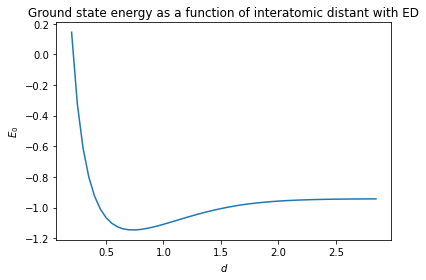

In [44]:
from tuto_utils import make_matrix

l_d = []
l_GS = []

for d in hamilt.keys():
    
    H = make_matrix(hamilt[d])
    eigvals, eigvecs = np.linalg.eigh(H)
    
    l_d.append(d)
    l_GS.append(eigvals[0])

plt.plot(l_d, l_GS)
plt.xlabel("$d$")
plt.ylabel("$E_0$")
plt.title("Ground state energy as a function of interatomic distant with ED")
print()



<div class="alert alert-block alert-info">

- **(*)** Can you describe the curve you obtained? Can you explain the various regimes (energy that increases/decreases with $R$)? What do you expect the distance between two hydrogen atoms in a dihydrogen molecule to be?

- **(*)** What is the computational complexity of diagonalizing a matrix of size $N$? What is the computational complexity of finding the ground state of a molecule with $n$ fermionic orbitals? Is this size a problem?
    
- **(#)** Do you know of ways to go around this problem?
    
</div>


Group 3 can jump to [Section 3 on QPE](#sec:qpe).
Group 4 can jump to [Section 4 on IQPE](#sec:iqpe).

For a hydrogen atom, we would get a similar result: at low distance, the strong force prevents the electron from entering the atom and at high distance, it is submitted to a potential in $\frac1r$. For 2 atoms, the interpretation is similar: at small distance, the nuclei are kept apart by the strong force. At high distance, each atom behaves almost independantly, and we get a potential in $\frac1r$ that correspond to the attraction of the electron of the first nucleus towards the second nucleus, and the other way around.

Direct diagonalization has complexity $\mathcal{O}(N^3)$

Here $N = 2^{2n}$, big problem.

Lanczos faster.

## 2. Variational Quantum Eigensolving (GROUPS 1 AND 2)

The goal of Variational Quantum Eigensolving (VQE) is to find an approximate ground-state energy by choosing a smart family of states. They are called variational states, or "ansatz" states, and are defined as
$$|\psi(\vec{\theta}) \rangle = U(\vec{\theta}) |\psi_0\rangle,$$
with $U(\vec{\theta})$ a circuit depending on parameters $\vec{\theta}$ (for instance the angles of rotation gates $R_x(\theta)$), and $|\psi_0\rangle$ an easy-to-prepare initial state. In the following, I will drop the arrow on $\vec{\theta}$, so that $\theta$ may denote several scalar parameters.

Once they are prepared by the quantum processor (or **quantum processing unit**, QPU), the average energy of the Hamiltonian at hand $H(d)$ for this state, $$E(\theta)_r \equiv \langle \psi(\theta) | H(d) | \psi(\theta)\rangle,$$ can be estimated using the QPU. A classical optimizer then uses $E(\theta)_r$ to find the optimal parameters $\theta^*$ that minimize this energy.

In other words, VQE iteratively computes $$E(d) = \min_\theta \langle \psi(\theta) | H(d) | \psi(\theta)\rangle.$$ 

### Choice of ansatz

The choice of ansatz is crucial in VQE. It is usually motivated by physical arguments.




In O'Malley et al, the ansatz is chosen to be
$$|\psi(\theta) \rangle = e^{-i\theta X_0 Y_1} |01\rangle.$$
This ansatz is inspired from quantum chemistry theory and goes under the name of "Unitary Coupled Cluster" (UCC) ansatz.


<div class="alert alert-block alert-info">
    
- **(*)** Why do O'Malley et al start from state $|01\rangle$? What is the name of this state in chemistry?
- **(*)** What are the inspirations behind the choice of a variational state? (for instance, what is the influence of increasing the number of variational parameters?)
- **(*)** What hardware constraints should one take into account when picking a variational state?
</div>
    
    
We now want to design a quantum circuit that creates such a state. O'Malley et al take the following variational circuit:

<div align="center"><img src="data/omalley_fig1.png" width="50%"></div>

<div class="alert alert-block alert-info">
    
- **(*)** Can you prove that this circuit indeed corresponds to our ansatz $e^{-i\theta X_0 Y_1} |01\rangle$ (up to a global phase)?
</div>

In the next cell we create the ansatz circuit (see https://myqlm.github.io/getting_started.html#a-simple-variational-algorithm for a simple example).

We note that since $\theta$ is a variable, we need to declare it as such.


(Note: you can safely replace the $R_x(\pi)$ gate with a $X$ gate as they are related by a global phase: $R_x(\pi) = i X$)

In [38]:
from qat.lang.AQASM import Program, X, RY, RX, RZ, CNOT

prog = Program()
# we declare a variable 'theta'
theta = prog.new_var(float, "\\theta")
# we allocate 2 qubits
qbits = prog.qalloc(2)

prog.apply(X, qbits[1])
prog.apply(RY(np.pi / 2), qbits[0])
prog.apply(RX(np.pi / 2), qbits[1])
prog.apply(CNOT, qbits)
prog.apply(RZ(theta), qbits[1])
prog.apply(CNOT, qbits)
prog.apply(RY(np.pi / 2), qbits[0])
prog.apply(RX(np.pi / 2), qbits[1])

circ = prog.to_circ()
%jsqatdisplay circ

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### 2.a) Execution on perfect qubits

We now perform the actual VQE simulation with a perfect (simulated) quantum computer, which we will also refer to as a "Quantum Processing Unit" (QPU).

Intuitively, a QPU may be regarded a black box that takes, as an input, a quantum job comprising a quantum circuit $U$ and an observable $H$ and returns, as an output, an estimate of $E = \langle 0\dots 0 | U^\dagger H U |0\dots 0\rangle$.

Using this QPU, we could write the optimization loop ourselves, in the form of a *for* loop that proposes new parameters $\theta_{i+1}$ after the computation of $E(\theta_i)$). Instead, we use existing tools performing this optimization natively.

We do this by constructing a "smart" QPU that, instead of accepting simple jobs $(U, H)$, accepts parametric jobs $(U(\theta), H)$, and whose task is to minimize $E = \langle 0\dots 0 | U^\dagger(\theta) H U(\theta) |0\dots 0\rangle$.

This smart QPU is constructed by prepending to the simple QPU a so-called "plugin" that carries out the optimization loop (with a method that can be chosen at will).

Let us note that the ``qpu`` object of the stack can be replaced with a "true" QPU, i.e a true quantum processor! (see https://myqlm.github.io/myqlm_specific/qiskit.html#module-qat.interop.qiskit.providers if you want to try with an IBM processor!)

#### One VQE execution for a given bond distance

Let us take a first example for a given bond distance $d=0.2 A$ (taking inspiration from https://myqlm.github.io/getting_started.html#a-simple-variational-algorithm):

Text(0.5, 0, 'variational step')

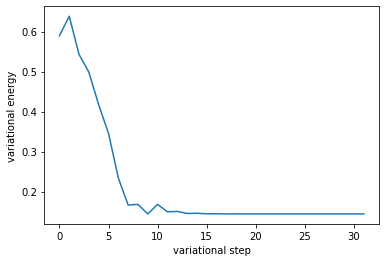

In [68]:
from qat.qpus import PyLinalg
from qat.plugins import ScipyMinimizePlugin
qpu = PyLinalg()
plugin = ScipyMinimizePlugin(method='Nelder-Mead')

smart_qpu = plugin | qpu

# run the variational computation
job = circ.to_job(observable = hamilt[0.2], nbshots = 100)
result = smart_qpu.submit(job)

# plot the variational energy as a function of the optimization step
plt.plot(eval(result.meta_data["optimization_trace"]))
plt.ylabel("variational energy")
plt.xlabel("variational step")



<div class="alert alert-block alert-info">
    
- **(*)** Does the result depend on the classical optimizer used? What happens when you change "Nelder-Mead" to another scipy optimizer (check the documentation of scipy.optimize.minimize: https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)?

- **(*)** On a real QPU, how is the average energy of a given state, $\langle \psi | H|\psi \rangle$, measured? (how do we handle the fact that our $H$ is a sum of (possibly) non-commuting Pauli observables?)

- **(*)** Why do we expect a statistical error on this estimate? How does it scale with the number of measurements (also called shots)?

- **(*)** Can you check that you obtain this behavior with the QPU simulator above (for a given $\theta$)? This can be done by using the "nbshots" parameter of the ``to_job`` method (no parameter, or nbshots=0, means an infinite number of shots and hence no statistical errors).
    
</div>

#### VQE for all bond distances

We now carry out the VQE procedure for all bond distances:

In [58]:
l_VQE_GS = []

for d in hamilt.keys():
    job = circ.to_job(observable = hamilt[d], nbshots = 100)
    result = smart_qpu.submit(job)
    l_VQE_GS.append(result.value)

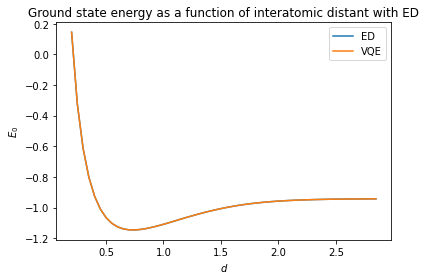

In [59]:
plt.plot(l_d, l_GS, label = 'ED')
plt.plot(l_d, l_VQE_GS, label = 'VQE')
plt.xlabel("$d$")
plt.ylabel("$E_0$")
plt.title("Ground state energy as a function of interatomic distant with ED")
plt.legend()
print()

In [62]:
l_VQE_GS[:10]

[0.14421033384507054,
 -0.32393924517088585,
 -0.612974544557848,
 -0.800510261380436,
 -0.9252596050459732,
 -1.0090090164925494,
 -1.0653917808231923,
 -1.1023261929650405,
 -1.1255942623584867,
 -1.1389447440785323]

In [55]:
l_GS[:10]

[0.14421033191099067,
 -0.3239392452849162,
 -0.6129745446098809,
 -0.8005102614889511,
 -0.9252596050468844,
 -1.0090090168725934,
 -1.06539178102544,
 -1.102326193007416,
 -1.1255942623603348,
 -1.138944744265075]



<div class="alert alert-block alert-info">

- **(*)** What do you observe? Is the VQE energy accurate compared to "chemical accuracy" (what is chemical accuracy? why is this value chosen?)
- **(*)** Can some values be lower than the exact ground-state energy? Why?
    
</div>

<a id='noisy_qubits'></a>
### 2.b) Noisy qubits

We now replace the perfect QPU of the above subsection by a simulator that takes into account hardware noise, which we will call a "noisy QPU".

A noisy QPU mimics the effect of quantum noise (decoherence). Here, we choose a very simple noise model called **depolarizing noise**.

#### A crash course into noisy quantum states and noisy gates

##### Noisy quantum states
A "noisy" qubit cannot be described by a ket $|\psi\rangle$ because it is (by definition) entangled with its environment (only the ket $|\Psi_\mathrm{tot}\rangle$ describing the qubit AND its environment is well defined). One can, instead of manipulating $|\Psi_\mathrm{tot}\rangle$ (a very large object with too much information for our purposes!), manipulate a new object called the **"density matrix"**, often denoted as $\rho$. It describes the fact that when a qubit gets entangled with its environment, one loses information on the qubit's state. It becomes a "statistical mixture" of several pure states: typically, $\rho$ can be decomposed as $$\rho = \sum_i p_i |\psi_i\rangle \langle \psi_i |,$$ which you should interpret as the qubit is in state $|\psi_i\rangle$ with probability $p_i$. A perfect qubit is described by a density matrix $\rho = |\psi\rangle\langle \psi|$ (its state is perfectly known; it is also known as a **pure state**, as opposed to a **mixed state**).


<div class="alert alert-block alert-success">
    
For more information about density matrices, read your notes from Lecture n°4 of the EA!
</div>

##### Noisy gates
In this picture, a "noisy gate" is, mathematically speaking, a function $\rho \mapsto \mathcal{E}(\rho)$ that maps an input density matrix $\rho$ to an output density matrix $\mathcal{E}(\rho)$. A perfect gate, described by a unitary matrix $U$ (see lecture 1), acts on $\rho$ as $\mathcal{E}(\rho) =\mathcal{U}(\rho) = U \rho U^\dagger$. The most general expression for a noisy gate is:

$$\mathcal{E}(\rho) = \sum_{k=0}^{K-1} E_k \rho E_k^\dagger,$$

with the operators $E_k$ called "Kraus operators". Usually, one can decompose a noisy gate as a perfect gate $\mathcal{U}$ followed by (or composed with) a noise map $\mathcal{E}$.


"Depolarizing noise" is a simple noise map with simple Kraus operators. In the one-qubit case, $E_0 = \sqrt{1 -p} I$, $E_i = \sqrt{p/3} \sigma_i$ with $\sigma_1$ the $\sigma^x$ Pauli matrix and so on.

<div class="alert alert-block alert-info">
    
- **(*)** If one starts from a pure state $\rho=|\psi\rangle\langle\psi|$ and applies a depolarizing noise, what does the output density matrix look like? What happens in the limit when $p\rightarrow 0$?

</div>
<div class="alert alert-block alert-success">

Alternative descriptions of decoherence exist (see the Lindblad equation you learned about in Lecture n°4). You will also learn more about decoherence in Lecture n°9.
</div>

#### Back to our noisy QPU
In a very simplified picture, we choose to apply this noise after each gate (which we suppose to be perfect). This is achieved using another "plugin" that transforms a perfect QPU into a noisy "depolarized" QPU.

Here, we have to choose a depolarizing "probability". This is the probability that a depolarization event occurs. It is usually larger for two-qubit gates as their duration is longer than one-qubit gates, thereby increasing the probability that a noisy event occurs. Thus we must choose two numbers, ``prob_1qb`` and ``prob_2qb``, for one and two-qubit gates, respectively.

In [ ]:
from qat.qpus import PyLinalg
from depolarizing_plugin_vec import DepolarizingPluginVec
from qat.plugins import ScipyMinimizePlugin

plugin = ScipyMinimizePlugin(method='Nelder-Mead')

# we instantiate a plugin that turns a perfect qpu into a noisy qpu:
depol = DepolarizingPluginVec(prob_1qb=0.005, prob_2qb=0.01)  # 0.005 corresponds to 0.5% probability
qpu = PyLinalg()

noisy_qpu = depol | qpu

smart_noisy_qpu = plugin | noisy_qpu

# perform variational computation for all distances
# ...

In [ ]:
# plot energies



<div class="alert alert-block alert-info">

- **(*)** What do you observe? Is "chemical accuracy" (what is it?) reached?
- **(*)** What noise levels would be needed to observe chemical accuracy?
- **(*)** How does the error evolve with the depolarizing error (you can assume a fixed ratio between the one and two-qubit depolarizing probabilities)?
    
</div>

- **(#)** (BONUS) You can easily get access to the variational parameters $\theta^*$ at convergence (by inspecting the contents of ``res[d].meta_data`` above), and execute the corresponding circuit $U(\theta^*)$ on a true quantum computer by replacing the ``qpu`` or ``noisy_qpu`` instance above by an instance of a (e.g) IBM "backend". See https://myqlm.github.io/myqlm_specific/qiskit.html#module-qat.interop.qiskit.providers. When you perform this run (for this you need to obtain an IBM token by registering on their website), how accurate are the results you obtain?

### 2.c) (GROUP 1 ONLY) Deeper into noise models

Take a look at the figure shown by O'Malley et al below. 

<div class="alert alert-block alert-info">
    
- **(*)** Are their results similar to yours? Can you list the possible causes of discrepancy?

</div>
    
<div align="center"><img src="data/omalley_fig3.png" width="50%"></div>

<div class="alert alert-block alert-info">
    
- **(*)** Can you briefly describe the working principle of "transmon qubits" used in O'Malley et al's work?

- **(*)** In the paper, what causes of errors are mentioned? What are the two characteristic decoherence times? What are their respective meaning? Are they related or not to the depolarizing noise model we used above?

- **(*)** What is the duration of the quantum gates used in the circuits? If you assume the error probability to follow an exponential law $$p = 1 - e^{-t/T_1}$$ and $$p' = 1 - e^{- 2t /T_\varphi}$$ with $T_\varphi = (1/T_2 - 1/(2 T_1))^{-1}$, what is the error probability of a one-qubit gate? of a two-qubit gate?
    
</div>


<div class="alert alert-block alert-info">

- **(*)** Given these probabilities, adjust the depolarizing probabilities you took and rerun the computations. Are you closer to the experimental curves?

</div>

### 2.d) (GROUP 2 ONLY) Zero-noise extrapolation

In the previous subsections, we saw how noise could degrade VQE results. We can try to reduce (or "mitigate") the effects of noise with a trick introduced in this paper: http://arxiv.org/abs/1801.03897 (p4). The method is simple: given a noisy QPU with noise level "$r$" ($r > 0$ if the computer is not perfect), one can try to artificially increase the noise strength $r$ to get the VQE energy $E(r)$, and then extrapolate to the $r\rightarrow 0$ limit. 

There are several tricks to artificially increase the noise level. The one proposed by Dumitrescu et al is to add $m$ pairs of CNOT gates after each CNOT gate of the variational circuit. In the perfect case, a pair of CNOT gates is an identity gate. In the noisy case, it approximately boils down to adding a noise of strength $2\epsilon$ (if we suppose that one CNOT gate incurs a noise of strength $\epsilon$). Thus, a CNOT gate in the initial circuit (strength $r=\epsilon$) is replaced by $1+2m$ CNOT gates, corresponding to a noise strength $r=(1+2m)\epsilon$. If we record the value of the VQE energy $E(m)$, the "noiseless" ($r=0$) extrapolation is $E(m=-1/2)$.

The cell below implements this idea.

In [ ]:
# perform variational computation with insertion of an increasing number of pairs of CNOTs
# ...

We now need to extrapolate $E(m)$ to the $m=-1/2$ limit. 

<div class="alert alert-block alert-info">

- **(*)** What form of fit can you choose? 
- **(*)** Is the "zero-noise extrapolation" closer to the exact energy? If there is still a deviation, where does it come from?
- **(#)** Can you think of other noise mitigation methods?

</div>

Here, given the shape of the curve, we choose a linear fit. The extrapolated energy is indeed better than the noisy one! It is not perfect because of the one-qubit noise.

In [ ]:
from scipy.optimize import curve_fit

# fit curve E(m) to extrapolate to zero-noise limit
# ...

<a id='sec:qpe'></a>
## 3. Standard Quantum Phase Estimation (GROUP 3)

In this section, we find an approximate ground-state energy with another method, the Quantum Phase Estimation (QPE) algorithm. We first focus on the "standard" version of this algorithm. In the next section (for group 2 only), we will turn to the variant used in the O'Malley et al paper, which is called "Iterative Quantum Phase Estimation".

<a id='qpe'></a>
#### Basic description of the QPE algorithm (see also: Lecture n°6)

A standard phase estimation algorithm consists in three main steps:
- Preparing the $m$-bit "phase" register in state $|+\rangle^m$ with Hadamard gates ($|+\rangle = (|0\rangle + |1\rangle)/\sqrt{2}$) and the "data" register in a state $|\psi\rangle$ that has a large enough overlap with the sought-after ground state $|\Psi\rangle$;
- Applying controlled-$U^{2^j}$ gates to both registers (with $j=0\dots m-1$), with $U$ the unitary whose phase $\varphi$ we want to find: $$U |\Psi\rangle = e^{2i\pi \varphi} |\Psi\rangle;$$
- Applying the inverse Quantum Fourier Tranform to the phase register.
Once this circuit is executed, one measures the qubits of the phase register (we call $\varphi_i\in\lbrace 0,1\rbrace$ the measurement result) to obtain a $m$-bit estimate $\hat{\varphi}$ of $\varphi$: $$\hat\varphi = \sum_{i=0}^{m-1} \frac{1}{2^{1+i}} \varphi_i.$$

In our case, $U$ assumes a very particular form: $U = \exp(-i H t_0)$, with $H$ the Hamiltonian whose ground state energy we want to find. Thus, $U |\Psi\rangle = e^{-i E t_0}|\Psi\rangle $ and therefore we can identify $2\pi \varphi = -E t_0$ so that we can compute an estimate $\hat{E}$ as $\hat{E} = -2\pi\hat{\varphi}/t_0$.

#### Making sure that the phase is within $]0, 1[$

Let us note that $\varphi$ can be known only up to a integer: for any $n\in \mathbb{Z}$, $\varphi' = \varphi + n$ is also an admissible eigenphase. This can cause a problem for the determination of the energy since it can be determined only up to $2\pi n/t_0$ as a consequence of this remark.

To avoid this problem, we are going to make sure that $\varphi$ corresponding to the ground-state energy $E$ satisfies $0<\varphi<1$. To this aim, we use the fact that the Hamiltonian is decomposed as $H = \lambda_0 + \sum_{i=1}^{M} \lambda_i P_i$ and that $\mathrm{Tr} P_i = 0$ $\forall i$. We apply QPE to $\tilde{H} = H - \lambda_0$. Since $\mathrm{Tr} \tilde H = 0$, it means that its ground state energy $E$ is negative.


<div class="alert alert-block alert-info">

- **(*)** Why does the fact that $\mathrm{Tr} \tilde{H} = 0$ imply that its ground-state energy is $\leq 0$?

</div> 
   
Then, if we pick $t_0$ such that $0 < t_0 < 2\pi/(-E)$, we will have $\varphi = -E t_0/(2\pi) \in ]0, 1[$.

<a id='trotterization'></a>
### 3.a) Circuit implementation of the controlled unitaries: Trotterization

Let us turn to the implementation of $U^{2^j} = \exp(-i 2^j H t_0) = \exp(-i\alpha H)$ as a quantum circuit. It is need for the second step of the QPE algorithm described above. $H$ is represented as a weighted sum of products of Pauli operators:
$$H = \sum_{i=1}^{M} \lambda_i P_i$$

It is quite easy to express the exponential of a product of Pauli operators $\exp(i\lambda P)$ as a quantum circuit. Before we can do this, we need  to expand the exponential of a sum as a product of exponentials. Since the terms of the sum do not commute, we cannot straightforwardly do this expansion. Instead, we use so-called "Trotter" identities to perform this expansion.

The first-order Trotter identity reads

$$\exp(\delta \sum_{i=1}^M A_i) = \prod_{i=1}^M \exp(\delta A_i) + O(\delta^2)$$

It becomes exact in the $\delta\rightarrow 0$ limit. The second-order Trotter identity reads

$$\exp(\delta \sum_{i=1}^M A_i) = \prod_{i=1}^M \exp(\delta A_i/2) \prod_{i=M}^{1} \exp(\delta A_i/2) + O(\delta^3)$$

To use either identity, we first decompose the Hamiltonian in the following way:

$$ \exp(-i \alpha H) = \prod_{k=1}^{N} \exp(-i \alpha /N H) $$

and then apply the Trotter identities to $\exp(-i \alpha /N H)$ with $\delta = \alpha / N$. For instance, if we use the first-order expansion, we obtain: 

$$ \exp(-i \alpha H) \approx \prod_{k=1}^{N} \prod_{i=1}^M \exp(-i\alpha \lambda_i / N P_i), $$

with a total Trotter error $O(\alpha^2 / N)$ (there are $N$ Trotter slices, each of which has a $O(\alpha^2/ N^2)$ error).

The function that builds the corresponding quantum routine is provided under the name ``make_controlled_exp_hamiltonian``.

In [ ]:
from qpe_utils import make_controlled_exp_hamiltonian

## uncomment the following line to see the documentation of the function.
# make_controlled_exp_hamiltonian?


<div class="alert alert-block alert-info">

- **(*)** Can you explain how the ``make_controlled_exp_hamiltonian`` function works based on the description of the Trotterization procedure above?
- **(*)** If a Hamiltonian contains $M$ noncommuting terms, how many $\exp(-i\alpha \lambda_i / N P_i)$ subcircuits will the $U$ circuit contain?
- **(*)** How to implement a single $\exp(-i\alpha P_i)$ term? Can you explain how the corresponding routine, ``construct_Rk_routine`` (in the ``qpe_utils`` module), works?
    
</div>

### 3.b) Quantum phase estimation routine

We now build the quantum routine corresponding to the QPE. We use the already implemented function ``make_controlled_exp_hamiltonian``.

In [ ]:
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import H, QRoutine, RX, Program
from qat.lang.AQASM import CNOT, RZ
from qat.lang.AQASM import QInt


def build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=1., n_trotter=1, order=1):
    """Construct the quantum phase estimation routine corresponding to a given Hamiltonian
    
    
    Args:
        hamiltonian (Observable): a Hamiltonian
        n_phase_bits (int): the number of phase bits
        t0 (float): the evolution time
        n_trotter (int): the number of Trotter steps
        order (int): Trotterization order
        
    Returns:
        QRoutine: a quantum routine for phase estimation with unitary U = exp(-i H t0)
    """
    routine = QRoutine()
    phase_reg = routine.new_wires(n_phase_bits)
    data_reg = routine.new_wires(hamiltonian.nbqbits)
    
    # Hadamard wall
    # ...
    
    # controlled unitaries
    # ...
        
    # now apply inverse QFT
    # ...
    
    return routine


<div class="alert alert-block alert-info">
    
- **(*)** Using ``%qatdisplay``, plot the quantum routine to check that it has the necessary building blocks.
    
</div>

In [ ]:
# an example:
# qpe_routine = ... 

%qatdisplay qpe_routine

### 3.c) Executing the QPE

Now that we have the core QPE routine, we write a high-level function that builds the circuit, submits it to a QPU and then post-processes the output. It returns the probabilities of getting each possible output (there are $2^m$ possible outputs).


Instead of using gates to prepare the ground state, we can, to make our life simpler, apply instead a ``StatePreparation`` routine that exactly prepares a given quantum state ``psi_init`` with the syntax ``prog.apply(StatePreparation(psi_init), phase_reg, data_reg)``.

In [ ]:
from qat.lang.AQASM import AbstractGate
StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray])


def perform_qpe(qpu, hamiltonian, psi0, n_phase_bits, n_trotter, nbshots=0, t0=1.0, order=1, verbose=False):
    """
    Args:
        qpu (QPU): a QPU
        hamiltonian (Observable): a Hamiltonian
        psi0 (np.array): an eigenvector of H
        n_phase_bits (int): number of bits for the phase
        n_trotter (int): number of trotter slices
        nbshots (int, optional): number of shots.
            Defaults to 0 (corresponding to an infinite number of shots)
        t0 (float, optional): time in U = exp(- i H t0). Defaults to 1.
        order (int, optional): Trotterization order. Defaults to 1.
        verbose (bool, optional): for verbose output. Defaults to False.
        
    Returns:
        np.array: the vector of probabilities (frequencies) of obtaining each output (from 0 to 2^{m-1})
    """
    # we prepare the initial state |0...0>|psi0> of the register
    phase_reg_in = np.zeros((2**n_phase_bits,))
    phase_reg_in[0] = 1.0 # |0>^n_phase_bits
    psi_init = np.kron(phase_reg_in, psi0)
    
    # we initialize the program
    prog = Program()
    phase_reg = prog.qalloc(n_phase_bits, class_type=QInt, reverse_bit_order=False)
    data_reg = prog.qalloc(hamiltonian.nbqbits)

    # we use a StatePreparation gate to prepare psi_init
    # this is somewhat of a trick: this assumes we can prepare exactly the ground state
    # if we don't want to cheat we can replace the StatePreparation routine
    # by a routine (gates) that prepare an approximate ground state
    prog.apply(StatePreparation(psi_init), phase_reg, data_reg)

    # we call the main QPE routine
    pea_routine = build_qpe_routine_for_hamiltonian(hamiltonian, n_phase_bits, t0=t0,
                                                    n_trotter=n_trotter, order=order)
    prog.apply(pea_routine, phase_reg, data_reg)

    # we generate the corresponding circuit and execute it
    # ...

    # we store the output probabilities in a vector
    probs = np.zeros(2**n_phase_bits)
    # ...

    return probs

### 3.d) Study of the influence of the parameters

Before we execute the QPE for the Hamiltonians corresponding to the various distances, we study the influence of the various parameters on the accuracy for a fixed distance (here $d = 0.2 A$).

<div class="alert alert-block alert-info">

- **(*)** Plot the probability distribution of the ouputs of the QPE for various numbers of Trotter steps and phase qubits. What do you observe?
    
</div>

In [ ]:
h = hamilt[0.2]
t0 = qpe_t0[0.2]
# ...


<div class="alert alert-block alert-info">
    
- **(*)** What is the number of Trotter steps used by O'Malley et al?
- **(*)** What is the Trotterization order they choose (first-order or second-order)?
- **(*)** Does the order of the terms matter when trotterizing the exponential of a Hamiltonian?
- **(*)** To keep a fixed Trotter error upon increasing the final time $t_0$, how must one change the number of Trotter steps with respect to $t_0$?
    
</div>

### 3.e) QPE energy as a function of distance (perfect qubits)

Below, we write a short function that launches the QPE procedure for several distances and stores the result in a list.
NB: we are assuming we can prepare a perfect ground state!

In [ ]:
def launch_qpe(qpu, n_trotter, n_phase_bits):
    """launch a QPE computation for a given QPU"""
    E_QPEs = []
    for ind, d in enumerate(hamilt.keys()):
        h = hamilt[d]
        
        # ... call perform_qpe etc.
        
    return E_QPEs

In [ ]:
from qat.qpus import PyLinalg
# n_trotter = 
# n_phase_bits = 
qpu = PyLinalg()
# call launch_qpe

In [ ]:
# plot the results


<div class="alert alert-block alert-info">
    
- **(*)** What do you observe? How does it compare with the results (see Figure in section 2.b) above) in the paper?
- **(*)** What happens when you increase the number of Trotter steps?
    
</div>

### 3.f) QPE energy as a function of distance (noisy qubits)

We now perform the same quantum computation, only with a noisy QPU. 
Read carefully [subsection 2.b) above](#noisy_qubits) to learn about noisy qubits and noisy gates, and their implementation with myQLM.

In [ ]:
# n_trotter = 
# n_phase_bits = 

from depolarizing_plugin_vec import DepolarizingPluginVec
qpu = PyLinalg()
depol = DepolarizingPluginVec(prob_1qb=0.005, prob_2qb=0.01)
noisy_qpu = depol | qpu

# call launch_qpe

In [ ]:
#  plot


<div class="alert alert-block alert-info">

- **(*)** What do you observe? Does noise degrade the accuracy on the energy? Is chemical accuracy reached?
- **(*)** Can some values be lower than the exact ground-state energy? Why?
    
</div>

<a id='sec:iqpe'></a>
## 4. Iterative quantum phase estimation (GROUP 4)

In this section, we turn to a variant to standard QPE called "Iterative QPE". It is described e.g in http://dx.doi.org/10.1103/PhysRevA.76.030306.

The idea is to determine the bits of the phase estimate $\hat{\varphi}$ one by one starting from the bit with least weight. The advantage of IQPE is that it requires only one ancilla (aka phase) qubit. The price to pay is that one uses the result obtained for the previous bit to obtain the next bit.


Here is a basic description of the algorithm:
- Initialize a variable $\omega = 0$, and $j = m$.
- While $j > 0$:
    - Prepare data register in state $\psi$ and phase register in state $|+\rangle$;
    - Apply a controlled-$U^{2^{j-1}}$ gate to both registers (with the control on the phase register)
    - Apply a $R_z(\omega)$ rotation, followed by a $H$ gate, to the phase register
    - Measure phase register: get a bit $\varphi_j$ (can be only 0 or 1).
    - Update: $\omega \leftarrow \omega/2 - 2 \pi \varphi_j / 4$ and $j \leftarrow j -1$.
- Return $\hat{\varphi} = - \omega / \pi$, 

This procedure is equivalent to standard QPE described [in this section](#qpe).

<div class="alert alert-block alert-info">
    
- **(*)** Can you prove that this procedure indeed returns a binary approximation $\hat{\varphi}$ to the phase, like standard QPE (read the beginning of section 3 for a reminder on QPE)?
    
</div>

To construct the circuit corresponding to the controlled-$U^{2^{j-1}}$ operation, we are going to use the function ``make_controlled_exp_hamiltonian``: 

In [ ]:
from qpe_utils import make_controlled_exp_hamiltonian

## uncomment the following line to see the documentation of the function.
# make_controlled_exp_hamiltonian?

Read carefully the [section on Trotterization](#trotterization).

<div class="alert alert-block alert-info">
    
- **(*)** Can you explain how the ``make_controlled_exp_hamiltonian`` function works based on the description of the Trotterization procedure above?
- **(*)** If a Hamiltonian contains $M$ noncommuting terms, how many $\exp(-i\alpha \lambda_i / N P_i)$ subcircuits will the $U$ circuit contain?
- **(*)** How to implement a single $\exp(-i\alpha P_i)$ term? Can you explain how the corresponding routine, ``construct_Rk_routine`` (in the ``qpe_utils`` module), works?
    
</div>

We can now write the full IQPE function by closely following the above description of the algorithm.

Note: Instead of using gates to prepare the ground state, we can, to make our life simpler, apply instead a ``StatePreparation`` routine that exactly prepares a given quantum state ``psi_init`` with the syntax ``prog.apply(StatePreparation(psi_init), phase_reg, data_reg)``.

In [ ]:
from qat.lang.AQASM.qftarith import IQFT
from qat.lang.AQASM import H, QRoutine, RX, Program
from qat.lang.AQASM import CNOT, RZ
from qat.lang.AQASM import QInt
from qat.lang.AQASM import AbstractGate
StatePreparation = AbstractGate("STATE_PREPARATION", [np.ndarray])


def perform_iqpe(qpu, hamiltonian, psi0, n_phase_bits, n_trotter, t0=1.0, order=1, verbose=False):
    """
    Args:
        qpu (QPU): a QPU
        hamiltonian (Observable): a Hamiltonian
        psi0 (np.array): an eigenvector of H
        n_phase_bits (int): number of bits for the phase
        n_trotter (int): number of trotter slices
        verbose (bool, optional): for verbose output. Defaults to False.
        
    Returns:
        float: the estimated phase phi corresponding to U = exp(2 i \pi phi) = exp(- i H t0)
    """
    # we prepare the initial state |0>|psi0> of the register
    phase_reg_in = np.zeros((2,))
    phase_reg_in[0] = 1.0 # |0>
    psi_init = np.kron(phase_reg_in, psi0)
    
    omega = 0.0
    for j_ind in range(n_phase_bits, 0, -1):
        # we initialize the program
        prog = Program()
        phase_reg = prog.qalloc(1, class_type=QInt, reverse_bit_order=False)
        data_reg = prog.qalloc(hamiltonian.nbqbits)

        # we use a StatePreparation gate to prepare psi_init
        # this is somewhat of a trick: this assumes we can prepare exactly the ground state
        # if we don't want to cheat we can replace the StatePreparation routine
        # by a routine (gates) that prepare an approximate ground state
        prog.apply(StatePreparation(psi_init), phase_reg, data_reg)

        # apply gates
        # ...
        
        # we generate the corresponding circuit and execute it
        # ...

        # update omega
        # ...
       
    # return answer
    # ... 

### 4.a) Studying IQPE at a fixed distance

We start by studying the behavior of IQPE at fixed bond distance $R=0.2 A$.

In [ ]:
h = hamilt[0.2]
t0 = qpe_t0[0.2]
# ...



<div class="alert alert-block alert-info">

- **(*)** Study the influence of various numbers of Trotter steps and phase bits on the computed phase
    
</div>

In [ ]:
# ...

<div class="alert alert-block alert-info">
    
- **(*)** Display the quantum routine that you just wrote and tested using ``%qatdisplay``. Is is similar to the one used by O'Malley et al? Where do the discrepancies come from?

</div>

<div align="center"><img src="data/omalley_fig4.png" width="50%"></div>

    

### 4.b) Computing IQPE ground state energy for all distances (perfect qubits)

We now perform the IQPE computation for all distances.

In [ ]:
def launch_iqpe(qpu, n_trotter, n_phase_bits):
    E_QPEs = []
    for ind, d in enumerate(hamilt.keys()):
        h = hamilt[d]
        # ... call perform_iqpe
    return E_QPEs

In [ ]:
from qat.qpus import PyLinalg
# n_trotter = 
# n_phase_bits = 
qpu = PyLinalg()
# call launch_iqpe
# ...

In [ ]:
# plot


<div class="alert alert-block alert-info">
    
- **(*)** What do you observe? How does it compare with the results (see Figure in section 2.b) above) in the paper?
- **(*)** What happens when you increase the number of Trotter steps?
    
</div>

### 4.c) Computing the IQPE ground-state energy for all distances (noisy qubits)

We now perform the same quantum computation, only with a noisy QPU. 
Read carefully [subsection 2.b) above](#noisy_qubits) to learn about noisy qubits and noisy gates, and their implementation with myQLM.

In [ ]:
from depolarizing_plugin_vec import DepolarizingPluginVec

depol = DepolarizingPluginVec(prob_1qb=0.01, prob_2qb=0.05)
qpu = PyLinalg()
noisy_qpu = depol | qpu

# call launch_iqpe
# ...

In [ ]:
# plot


<div class="alert alert-block alert-info">
    
- **(*)** What do you observe? Does noise degrade the results?
- **(*)** What happens when the noise level increases?
    
</div>

